In [4]:
!git clone https://github.com/Apoorva5036/garbage_classification_week1.git

Cloning into 'garbage_classification_week1'...
remote: Enumerating objects: 2622, done.
remote: Counting objects: 100% (2622/2622), done.
remote: Compressing objects: 100% (2615/2615), done.
remote: Total 2622 (delta 56), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (2622/2622), 21.18 MiB | 31.71 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [5]:
import os

data_path = '/content/garbage_classification_week1/dataset'
print("Classes:", os.listdir(data_path))  # should list class folders like 'glass', 'metal', etc.


Classes: ['cardboard', 'glass', 'plastic', 'trash', 'metal', 'paper']


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Dataset path (update if needed)
dataset_path = "/content/garbage_classification_week1/dataset"

# Image settings
image_size = (260, 260)
batch_size = 32

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 2462 files belonging to 6 classes.
Using 1970 files for training.
Found 2462 files belonging to 6 classes.
Using 492 files for validation.


Found 2462 files belonging to 6 classes.
Using 1970 files for training.
Found 2462 files belonging to 6 classes.
Using 492 files for validation.


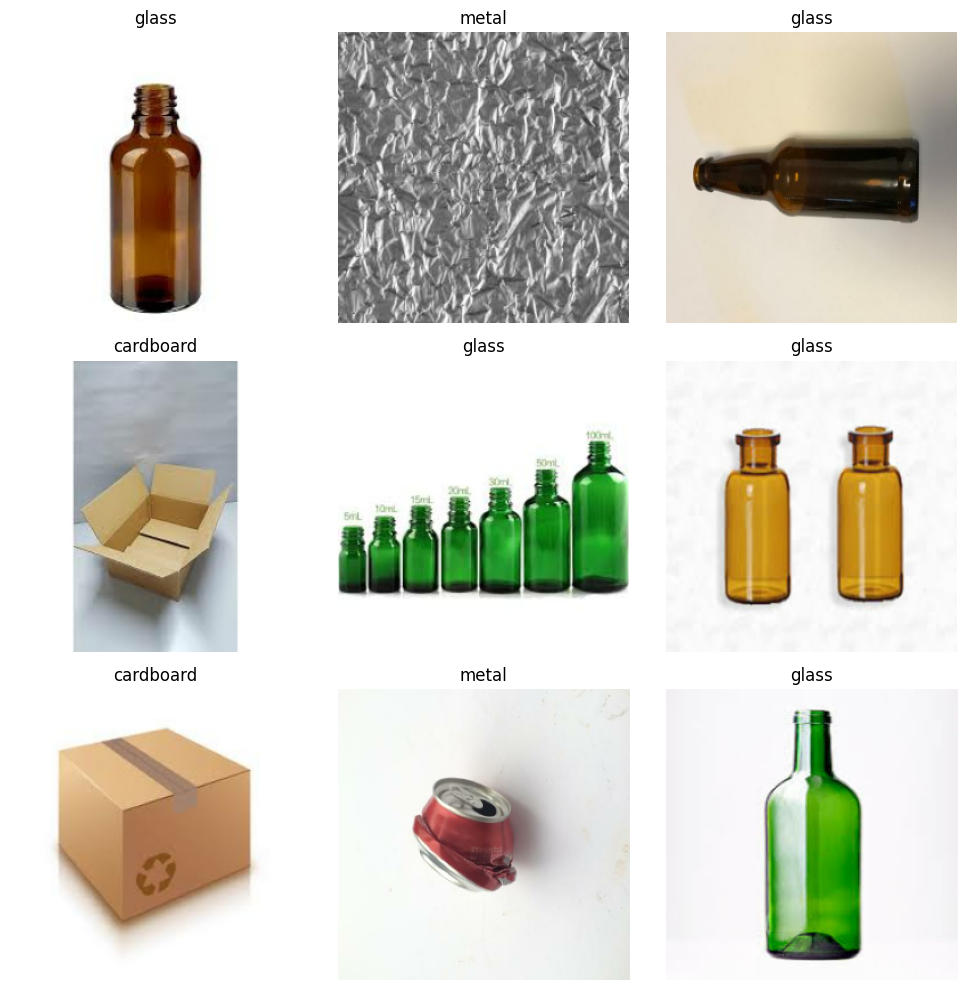

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Dataset path
dataset_path = "/content/garbage_classification_week1/dataset"
image_size = (260, 260)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Load raw training dataset (before mapping)
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# Load raw validation dataset
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# Save class names before mapping (important!)
class_names = raw_train_ds.class_names

# Normalize datasets
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

# Plot first 9 training images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [8]:
# Data augmentation block
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])


In [ ]:
augmented_train_ds = raw_train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).map(
    lambda x, y: (normalization_layer(x), y)
).prefetch(buffer_size=AUTOTUNE)


In [ ]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import layers, models

# EfficientNetV2B2 base model
base_model = EfficientNetV2B2(
    include_top=False,
    weights='imagenet',
    input_shape=(260, 260, 3),
    pooling='avg'
)
base_model.trainable = False  # Freeze base for transfer learning

# Build the final model
model = models.Sequential([
    data_augmentation,                   # Your augmentation layer
    layers.Rescaling(1./255),            # Normalization
    base_model,                          # Pretrained EfficientNetV2B2
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=15
)


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 459s 7s/step - accuracy: 0.3858 - loss: 1.4993 - val_accuracy: 0.4614 - val_loss: 1.4329
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 413s 7s/step - accuracy: 0.4360 - loss: 1.4041 - val_accuracy: 0.4614 - val_loss: 1.4092
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 438s 7s/step - accuracy: 0.4430 - loss: 1.4024 - val_accuracy: 0.4614 - val_loss: 1.3967
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 445s 7s/step - accuracy: 0.4400 - loss: 1.3768 - val_accuracy: 0.4614 - val_loss: 1.3912
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 438s 6s/step - accuracy: 0.4250 - loss: 1.3852 - val_accuracy: 0.4614 - val_loss: 1.4081
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 426s 7s/step - accuracy: 0.4456 - loss: 1.3831 - val_accuracy: 0.4614 - val_loss: 1.4099
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 426s 7s/step - accuracy: 0.4436 - loss: 1.3592 - val_accuracy: 0.4614 - val_loss: 1.4013
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 424s 7s/step - accuracy: 0.4516 - loss: 1.3601 - val_accuracy: 0.4614 - v

In [9]:
!ls /content


garbage_classification_week1  sample_data


In [10]:
!ls /content/garbage_classification_week1


dataset  garbage_classification.ipynb  README.md


In [11]:
# 0. Clone the dataset repo
!git clone https://github.com/Apoorva5036/garbage_classification_week1.git

# 1. Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B2
import matplotlib.pyplot as plt
import os

# 2. Dataset path and settings
dataset_path = "/content/garbage_classification_week1/dataset"
image_size = (260, 260)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# 3. Load raw training and validation datasets
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

class_names = raw_train_ds.class_names

# 4. Define data augmentation and normalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])
normalization_layer = layers.Rescaling(1./255)

# 5. Augment & normalize training set
augmented_train_ds = raw_train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).map(
    lambda x, y: (normalization_layer(x), y)
).prefetch(buffer_size=AUTOTUNE)

# 6. Normalize validation set
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

# 7. Load EfficientNetV2B2 base model
base_model = EfficientNetV2B2(
    include_top=False,
    weights='imagenet',
    input_shape=(260, 260, 3),
    pooling='avg'
)
base_model.trainable = True

# Optional: freeze early layers for stability
for layer in base_model.layers[:100]:
    layer.trainable = False

# 8. Build final model
model = models.Sequential([
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# 9. Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 10. Set training callbacks
cb = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]

# 11. Train the model
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=cb
)


fatal: destination path 'garbage_classification_week1' already exists and is not an empty directory.
Found 2462 files belonging to 6 classes.
Using 1970 files for training.
Found 2462 files belonging to 6 classes.
Using 492 files for validation.
Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3949 - loss: 1.5625 

62/62 ━━━━━━━━━━━━━━━━━━━━ 778s 11s/step - accuracy: 0.3960 - loss: 1.5606 - val_accuracy: 0.5305 - val_loss: 1.2443
Epoch 2/25
41/62 ━━━━━━━━━━━━━━━━━━━━ 3:44 11s/step - accuracy: 0.5261 - loss: 1.2788

KeyboardInterrupt: 